# 对比实验

## 1 Baseline

### 1.1 导包

In [50]:
import time
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



# import logging

# # 创建一个logger
# logger = logging.getLogger(__name__)

# # 设置日志级别为INFO
# logger.setLevel(logging.INFO)

# # 创建一个控制台输出的Handler
# handler = logging.StreamHandler()
# logger.addHandler(handler)


### 1.2 导入模型

In [51]:
## 定义ResNet18分类器
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        # 加载预训练的ResNet18模型
        self.resnet = models.resnet18(pretrained=True)
        
        # 替换最后一层全连接层
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

num_classes = 10  # 假设有10个分类
model = ResNetClassifier(num_classes)
    
net = ResNetClassifier(10)
input_tensor = torch.randn(64, 3, 32, 32)       #  TODO: 切换成输入分类数据的维度
output_tensor = net(input_tensor)

output_tensor.shape

/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([64, 10])

### 1.3 定义训练过程

In [52]:
def train_and_evaluate(model, optimizer, scheduler, train_loader, val_loader, num_epochs, device):
    criterion = nn.BCEWithLogitsLoss()  # 使用二元交叉熵损失函数
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        model.train()
        start_time = time.time()
        model.to(device)
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            labels = F.one_hot((labels), num_classes=num_epochs).float()
            
            outputs = model(inputs).squeeze()  # 去掉额外的维度
            train_loss = criterion(outputs, labels)
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()
        train_mean_loss = epoch_train_loss / len(train_loader)
        train_losses.append(train_mean_loss)

        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = F.one_hot((labels), num_classes=num_classes).float()
            outputs = model(inputs).squeeze()
            outputs = torch.argmax(outputs, dim=1)
            outputs = F.one_hot(outputs, num_classes=num_classes).float()
            val_loss = criterion(outputs, labels)
            epoch_val_loss += val_loss.item()
        val_mean_loss = epoch_val_loss / len(train_loader)

        scheduler.step(val_mean_loss)
        val_losses.append(val_mean_loss)

        end_time = time.time()
        total_time = end_time - start_time
        current_lr = optimizer.param_groups[0]['lr']
        print(f'👉 optim:{optimizer.__class__.__name__} + sched:{scheduler.__class__.__name__} - [Epoch {epoch+1}/{num_epochs}], \
              Train Loss: {train_mean_loss:.4f}, Val Loss: {val_mean_loss:.4f}, Time: {total_time:.2f}, LR: {current_lr:.6f}')
    return train_losses, val_losses

# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
# val_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# # train_dataset[0][0].shape

# def get_optimizers(model, lr, name):
#     optimizers = {
#         'SGD': optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5),
#         'Adam': optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999)),
#         'RMSprop': optim.RMSprop(model.parameters(), lr=lr, alpha=0.9),
#         'AdamW': optim.Adamax(model.parameters(), lr=lr, weight_decay=1e-5),
#         'ASGD': optim.ASGD(model.parameters(), lr=lr, lambd=0.0001)
#     }  

#     return optimizers[name]

# def get_schedulers(optimizer, name):
#     schedulers = {
#         'constant': optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.0),
#         'step': optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1),
#         'exp': optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
#         'cos': optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200),
#         'reduce': optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
#         # 'warmup': optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: epoch / 10)
#     }
#     return schedulers[name]


# num_classes = 10  # CIFAR-10有10个类别
# lr = 0.01
# model = ResNetClassifier(num_classes)

# optim_name = 'SGD'
# scheduler_name = 'step'

# optimizer = get_optimizers(model, lr, optim_name)

# scheduler = get_schedulers(optimizer, scheduler_name)

# # 运行实验
# train_results = {}
# val_results = {}
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# name = f'{optim_name}_{scheduler_name}'

# train_results[name], val_results[name] = train_and_evaluate(model, optim_name, scheduler_name, optimizer, scheduler, train_loader, val_loader, device)


### 1.4 定义优化器

In [53]:
def get_optimizers(model, lr, name):
    optimizers = {
        'SGD': optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5),
        'Adam': optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999)),
        'RMSprop': optim.RMSprop(model.parameters(), lr=lr, alpha=0.9),
        'AdamW': optim.Adamax(model.parameters(), lr=lr, weight_decay=1e-5),
        'ASGD': optim.ASGD(model.parameters(), lr=lr, lambd=0.0001)
    }  

    return optimizers[name]

### 1.5 定义调度器

In [54]:
def get_schedulers(optimizer, name):
    schedulers = {
        'constant': optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.0),
        'step': optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01),
        'exp': optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
        'cos': optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200),
        'reduce': optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5),
        # 'warmup': optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: epoch / 10)
    }
    return schedulers[name]

### 1.6 读取数据

In [55]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

train_dataset[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 32, 32])

## 2. 对比实验

### 2.1. 优化器效果对比实验

In [56]:
def plot_results(results, title_txt, save_path):
    plt.figure(figsize=(8, 5))
    for name, losses in results.items():
        plt.plot(losses, label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title_txt)
    plt.legend()
    plt.savefig(save_path)
    plt.show()
    print(f'img saved: {save_path}')

In [60]:
import os

def run_experiments(num_classes, optims_list, scheds_list, lr, num_epochs, device, svae_path_root):
    """Run a set of experiments and plot the results."""
    train_dict = {}
    val_dict = {}
    for optim_name in optims_list:
        trian_results = {}
        val_results = {}
        for sched_name in scheds_list:
            print(f'Running experiment: {optim_name}, {sched_name}')
            model = ResNetClassifier(num_classes)                           # 每次都要初始化
            optimizer = get_optimizers(model, lr, optim_name)
            scheduler = get_schedulers(optimizer, sched_name)
            name = f'{optimizer.__class__.__name__}_{scheduler.__class__.__name__}'
            trian_results[name], val_results[name] = train_and_evaluate(model, optimizer, scheduler, train_loader, val_loader, num_epochs, device)
        plot_results(trian_results, f'Train Results Compare on {name}', save_path=os.path.join(svae_path_root, f'train_{optim_name}.jpg'))
        plot_results(val_results, f'Val Results Compare on {name}', save_path=os.path.join(svae_path_root, f'val_{optim_name}.jpg'))
        train_dict.update(trian_results)
        val_dict.update(val_results)
    plot_results(train_dict, 'Train Results Compare', save_path=os.path.join(svae_path_root, f'train_all.jpg'))
    plot_results(val_dict, 'Val Results Compare', save_path=os.path.join(svae_path_root, f'val_all.jpg'))
    print('Finished!')
    print(train_dict,val_dict)

In [61]:

optims_list = ['SGD', 'Adam', 'RMSprop', 'AdamW', 'ASGD']
scheds_list = ['constant', 'step', 'exp', 'cos', 'reduce']

epochs = 10
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_save_path = './assert/优化器'


Running experiment: SGD, constant


/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the 

👉optim:SGD + sched:StepLR - [Epoch 1/10],               Train Loss: 0.1658, Val Loss: 0.1367, Time: 10.64, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 2/10],               Train Loss: 0.1032, Val Loss: 0.1360, Time: 10.01, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 3/10],               Train Loss: 0.0799, Val Loss: 0.1358, Time: 10.02, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 4/10],               Train Loss: 0.0633, Val Loss: 0.1357, Time: 10.06, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 5/10],               Train Loss: 0.0514, Val Loss: 0.1355, Time: 10.38, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 6/10],               Train Loss: 0.0407, Val Loss: 0.1355, Time: 9.88, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 7/10],               Train Loss: 0.0332, Val Loss: 0.1357, Time: 10.31, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 8/10],               Train Loss: 0.0273, Val Loss: 0.1355, Time: 10.01, LR: 0.010000
👉optim:SGD + sched:StepLR - [Epoch 9/10],

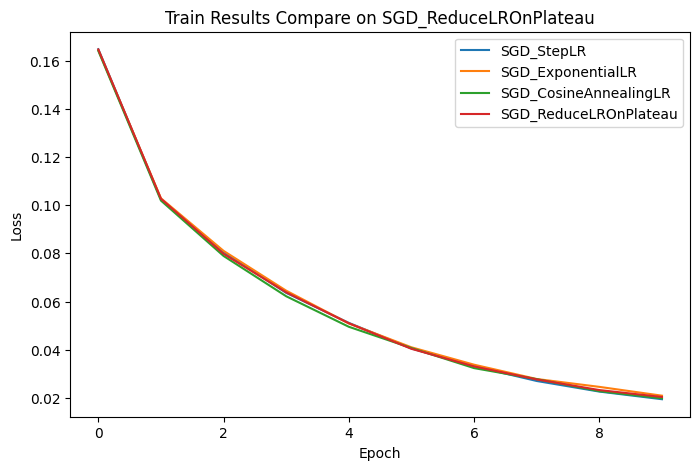

img saved: ./assert/优化器/train_SGD.jpg


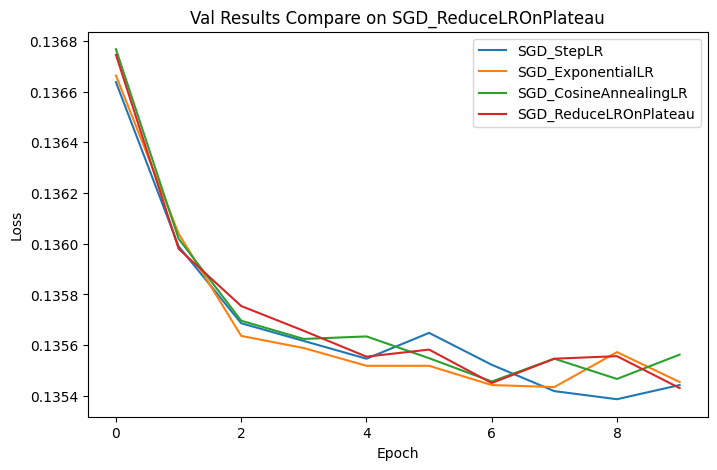

img saved: ./assert/优化器/val_SGD.jpg
Running experiment: Adam, constant


/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the 

👉optim:Adam + sched:StepLR - [Epoch 1/10],               Train Loss: 0.2970, Val Loss: 0.1438, Time: 11.51, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 2/10],               Train Loss: 0.2243, Val Loss: 0.1406, Time: 11.25, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 3/10],               Train Loss: 0.1867, Val Loss: 0.1396, Time: 11.57, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 4/10],               Train Loss: 0.1621, Val Loss: 0.1385, Time: 11.36, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 5/10],               Train Loss: 0.1431, Val Loss: 0.1379, Time: 11.11, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 6/10],               Train Loss: 0.1300, Val Loss: 0.1374, Time: 11.42, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 7/10],               Train Loss: 0.1194, Val Loss: 0.1373, Time: 11.54, LR: 0.010000
👉optim:Adam + sched:StepLR - [Epoch 8/10],               Train Loss: 0.1094, Val Loss: 0.1370, Time: 11.85, LR: 0.010000
👉optim:Adam + sched:StepLR - [Ep

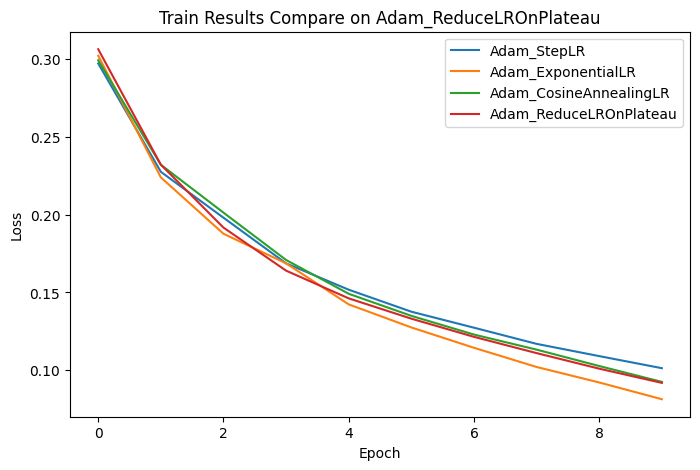

img saved: ./assert/优化器/train_Adam.jpg


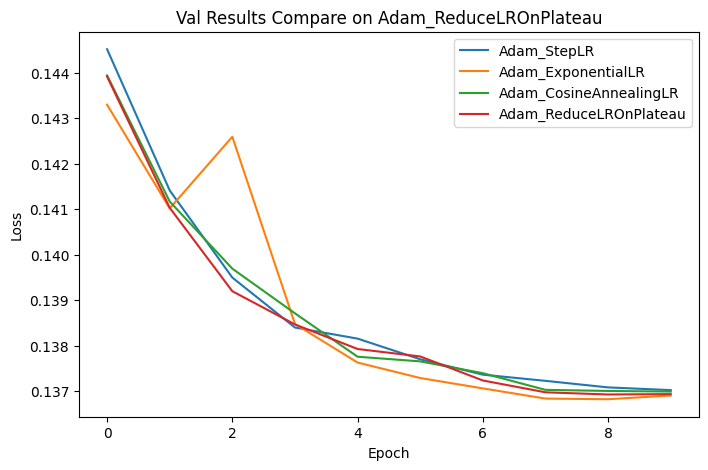

img saved: ./assert/优化器/val_Adam.jpg
Running experiment: RMSprop, constant


/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the 

👉optim:RMSprop + sched:StepLR - [Epoch 1/10],               Train Loss: 0.2879, Val Loss: 0.1428, Time: 10.11, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 2/10],               Train Loss: 0.1939, Val Loss: 0.1395, Time: 11.11, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 3/10],               Train Loss: 0.1623, Val Loss: 0.1385, Time: 10.90, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 4/10],               Train Loss: 0.1453, Val Loss: 0.1387, Time: 10.84, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 5/10],               Train Loss: 0.1345, Val Loss: 0.1376, Time: 10.06, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 6/10],               Train Loss: 0.1237, Val Loss: 0.1385, Time: 10.31, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 7/10],               Train Loss: 0.1163, Val Loss: 0.1373, Time: 10.53, LR: 0.010000
👉optim:RMSprop + sched:StepLR - [Epoch 8/10],               Train Loss: 0.1088, Val Loss: 0.1373, Time: 10.37, LR: 0.010000
👉optim:R

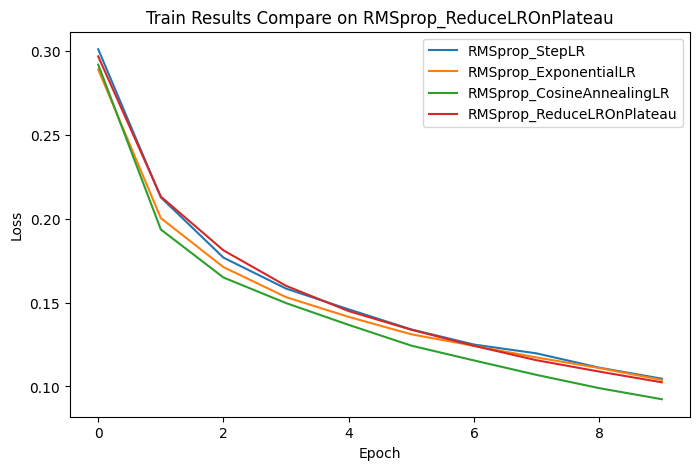

img saved: ./assert/优化器/train_RMSprop.jpg


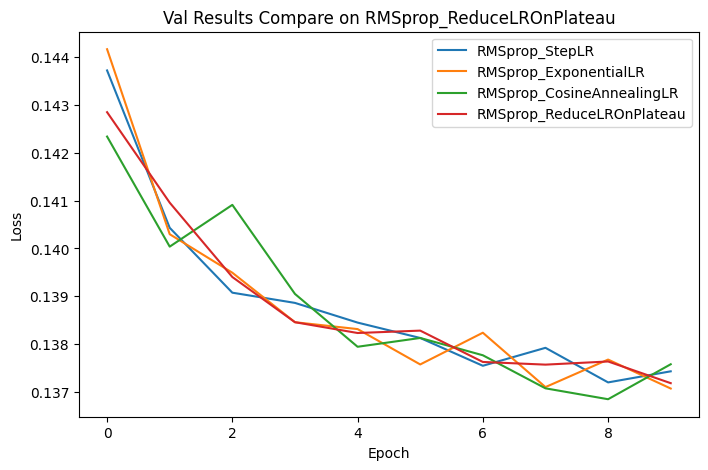

img saved: ./assert/优化器/val_RMSprop.jpg
Running experiment: AdamW, constant


/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the 

👉optim:Adamax + sched:StepLR - [Epoch 1/10],               Train Loss: 0.2630, Val Loss: 0.1412, Time: 11.63, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 2/10],               Train Loss: 0.1835, Val Loss: 0.1385, Time: 11.52, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 3/10],               Train Loss: 0.1498, Val Loss: 0.1376, Time: 11.46, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 4/10],               Train Loss: 0.1270, Val Loss: 0.1368, Time: 11.64, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 5/10],               Train Loss: 0.1157, Val Loss: 0.1367, Time: 11.47, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 6/10],               Train Loss: 0.1073, Val Loss: 0.1366, Time: 11.63, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 7/10],               Train Loss: 0.0979, Val Loss: 0.1364, Time: 11.54, LR: 0.010000
👉optim:Adamax + sched:StepLR - [Epoch 8/10],               Train Loss: 0.0891, Val Loss: 0.1362, Time: 11.62, LR: 0.010000
👉optim:Adamax + 

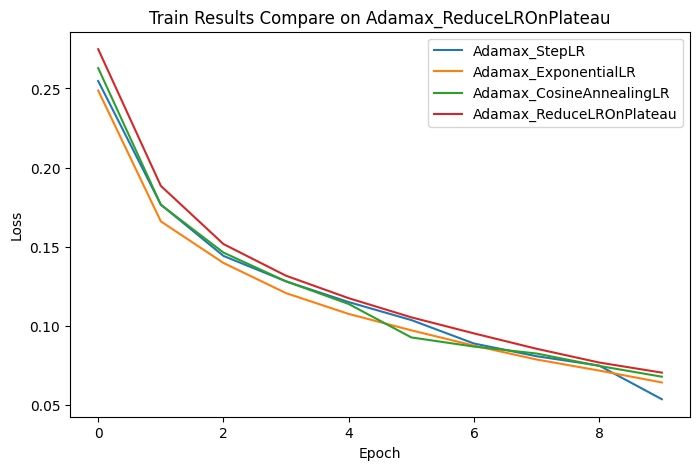

img saved: ./assert/优化器/train_AdamW.jpg


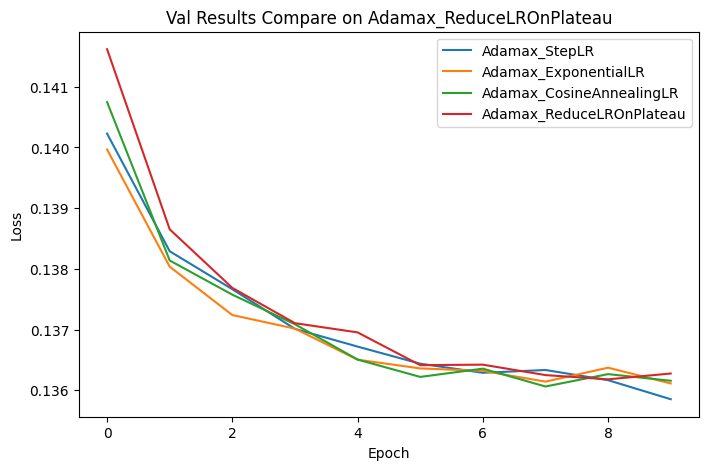

img saved: ./assert/优化器/val_AdamW.jpg
Running experiment: ASGD, constant


/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/envs/cv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the 

👉optim:ASGD + sched:StepLR - [Epoch 1/10],               Train Loss: 0.2522, Val Loss: 0.1402, Time: 15.18, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 2/10],               Train Loss: 0.1805, Val Loss: 0.1387, Time: 15.18, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 3/10],               Train Loss: 0.1536, Val Loss: 0.1379, Time: 15.34, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 4/10],               Train Loss: 0.1378, Val Loss: 0.1375, Time: 15.22, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 5/10],               Train Loss: 0.1267, Val Loss: 0.1372, Time: 15.30, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 6/10],               Train Loss: 0.1173, Val Loss: 0.1370, Time: 15.31, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 7/10],               Train Loss: 0.1092, Val Loss: 0.1368, Time: 15.41, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Epoch 8/10],               Train Loss: 0.1027, Val Loss: 0.1367, Time: 15.69, LR: 0.010000
👉optim:ASGD + sched:StepLR - [Ep

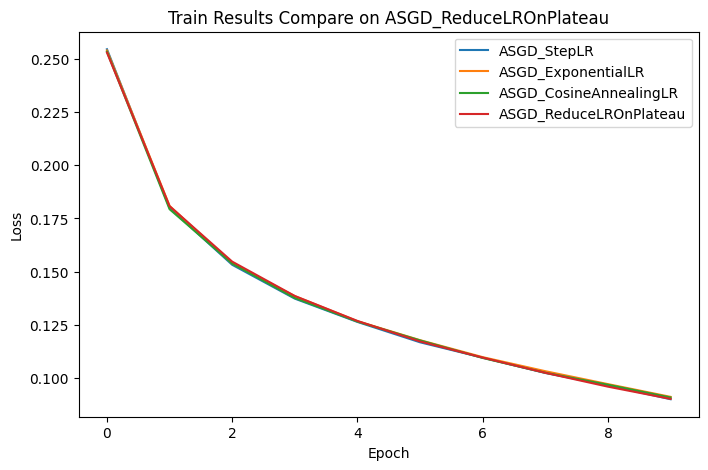

img saved: ./assert/优化器/train_ASGD.jpg


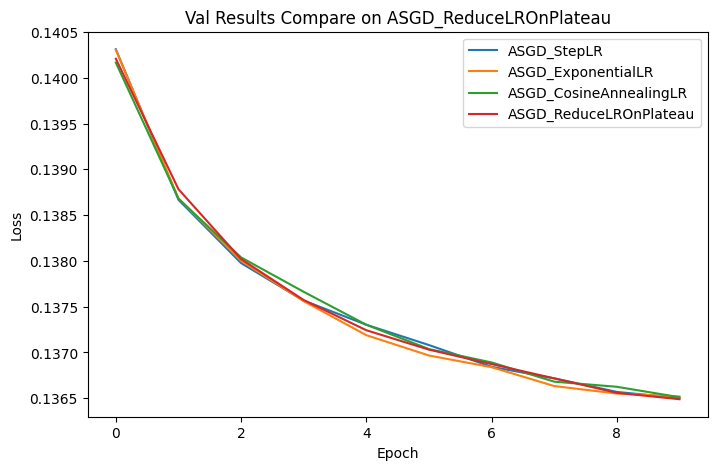

img saved: ./assert/优化器/val_ASGD.jpg


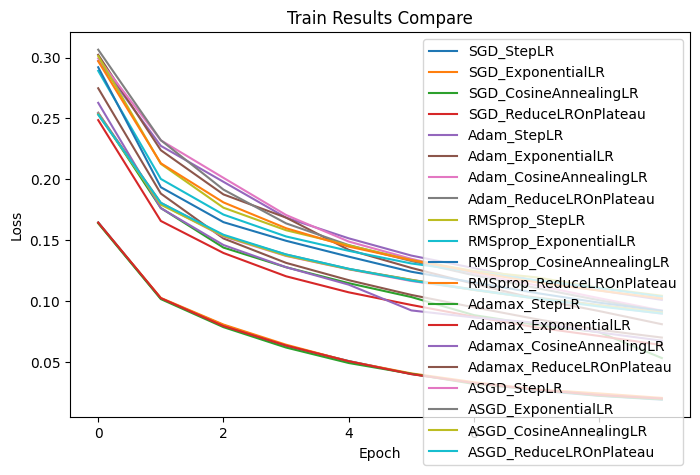

img saved: ./assert/优化器/train_all.jpg


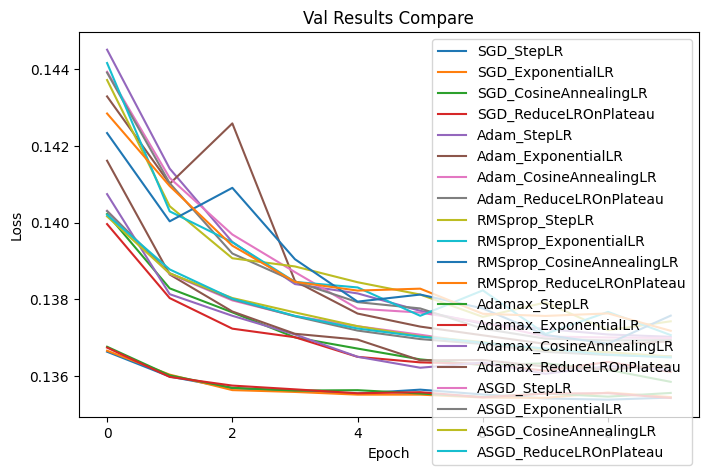

img saved: ./assert/优化器/val_all.jpg
Finished!
{'SGD_StepLR': [0.1647812688194425, 0.10243752990823116, 0.08055739979381146, 0.06360693370728084, 0.051128748358915684, 0.04049848604118428, 0.03314628310696891, 0.026998621147826238, 0.02260347857298401, 0.01942692852675524], 'SGD_ExponentialLR': [0.16437284091054022, 0.10286419696705726, 0.08103189474481451, 0.06450940751234817, 0.05089586760367617, 0.04098735641345115, 0.03376903440481733, 0.02782917622526836, 0.0245591605325108, 0.020898009646538634], 'SGD_CosineAnnealingLR': [0.16409091537584886, 0.10191717610963623, 0.07891681973281724, 0.0621829428579039, 0.04950717926177832, 0.04067082697635188, 0.032345637842260126, 0.027756660953378472, 0.02277095384819581, 0.0197927736438444], 'SGD_ReduceLROnPlateau': [0.16468413062679493, 0.10268496551915356, 0.07978000118852119, 0.06381340516621575, 0.05097018904112222, 0.040355669388123565, 0.033042079778007036, 0.027642172982778084, 0.023232359509102886, 0.0203605777520896], 'Adam_StepLR': [

In [62]:
# 开始实验
run_experiments(num_classes, optims_list, scheds_list, lr, epochs, device, img_save_path)